In [1]:
import kagglehub
import os
import re
import string 
import contractions
import numpy as np
import pandas as pd
import nltk 
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as tm
import pytorch_lightning as pl
# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.core.module import LightningModule
from pytorch_lightning.callbacks import EarlyStopping #ModelCheckpoint 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from pytorch_lightning.metrics.functional import accuracy, f1, auroc

nltk.download('punkt_tab')
warnings.filterwarnings("ignore")
stop_words = get_stop_words('en')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import TensorBoardLogger
# import numpy as np
# np.Inf = np.inf


c:\Users\annag\anaconda3\envs\sentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\annag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# EDA

In this part of the analysis, I will prepare a initial data analysis. This section will include a study of the distribution of the target variable, calculate the number of missing data, clean up comments with punctuation marks, links, stopwords etc. In the end of this part I will tokenize text.

In [12]:
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

train = pd.read_csv(path + '\\twitter_training.csv')
valid = pd.read_csv(path + '\\twitter_validation.csv')

train.columns = ['id', 'entity', 'sentiment', 'tweet']
valid.columns = ['id', 'entity', 'sentiment', 'tweet']

train.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [13]:
# check number of nulls in each column
train[['id', 'entity', 'sentiment', 'tweet']].isnull().sum()

id             0
entity         0
sentiment      0
tweet        686
dtype: int64

In [14]:
valid[['id', 'entity', 'sentiment', 'tweet']].isnull().sum()

id           0
entity       0
sentiment    0
tweet        0
dtype: int64

In [15]:
train.dropna(subset=['tweet'], inplace=True)

In [16]:
def draw_plot(df, name):
    """
    Print distribution plot of sentiment
    """
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'orange']
    df['sentiment'].value_counts().plot(kind='bar', color=colors)

    plt.title(f'Distribution of sentiment ({name} set)')
    plt.ylabel('Count')
    plt.xlabel('Sentiment')
    plt.show()

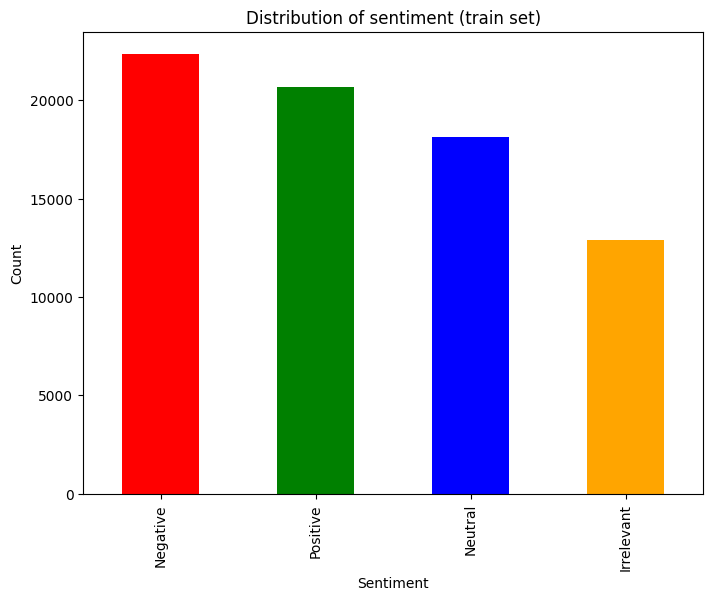

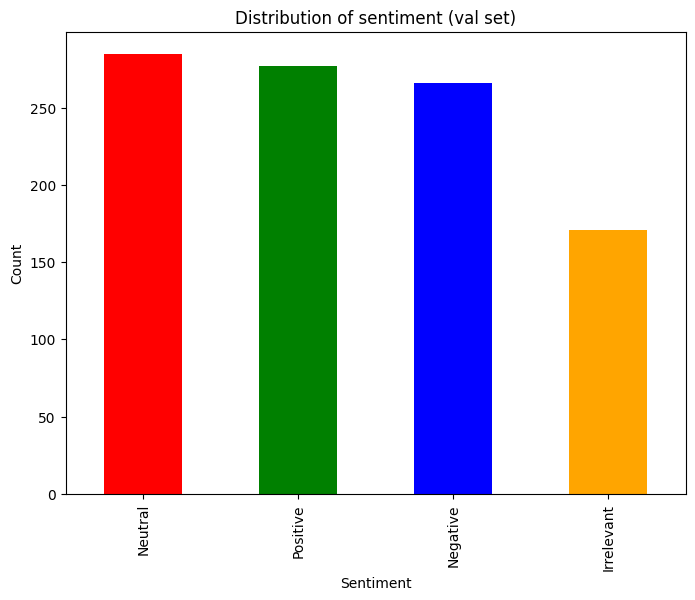

In [17]:
draw_plot(train, 'train')
draw_plot(valid, 'val')

In [18]:
def clean_text(text):
    """
    Clean input text by lowercasing and removing punctuation
    """
    # lower case
    text = text.lower() 
    # remove links
    text = re.compile(r"https?://\S+|www\.\S+").sub("", text)
    # remove punctuations
    table = str.maketrans('','',string.punctuation)
    text = text.translate(table)
    # remove unique char
    text = re.sub(r'(?:^| )\w(?:$| )', ' ',text).strip()
    # contractions
    text = " ".join([contractions.fix(word) for word in text.split()])

    replacements = {
        r"'s\b": "",
        r"\s+": " ",
    }

    for replace, by in replacements.items():
        text = re.sub(replace, by, text)

    return text.strip()

In [19]:
train['tweet_clean'] = train['tweet'].apply(lambda x: clean_text(x))
valid['tweet_clean'] = valid['tweet'].apply(lambda x: clean_text(x))

In [20]:
def remove_stopwords(text):
    """
    Tokenize text and remove stopwords.
    """
    text = text.apply(word_tokenize)
    text = text.apply(lambda x: [word for word in x if word not in stop_words])
    return text

In [21]:
train['tweet_no_stopwords'] = remove_stopwords(train['tweet_clean'])
train['tweet_no_stopwords'] = train['tweet_no_stopwords'].apply(lambda x: ' '.join(eval(str(x))))
valid['tweet_no_stopwords'] = remove_stopwords(valid['tweet_clean'])
valid['tweet_no_stopwords'] = valid['tweet_no_stopwords'].apply(lambda x: ' '.join(eval(str(x))))

# Modelling

In this part I will 

In [12]:
val, test = train_test_split(valid, test_size=0.33, random_state=42)

X_train = train['tweet_no_stopwords']
y_train = train['sentiment']

X_val = val['tweet_no_stopwords']
y_val = val['sentiment']

X_test = test['tweet_no_stopwords']
y_test = test['sentiment']

In [14]:
class DataStructure:
    def __init__(self,X,typedt,y_train=y_train,y_val=y_val,X_train=X_train,shuffle=True):
        self.X = X
        self.y_train = y_train
        self.y_val = y_val
        self.typedt = typedt
        self.X_train = X_train
        self.shuffle = shuffle

    def encode_data(self):
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(self.y_train)
        y_val = label_encoder.transform(self.y_val)
        if self.typedt == "train":
            return y_train
        else:
            return y_val
    
    def get_tokenizer(self):
        tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
        tokenizer.fit_on_texts(self.X_train)
        return tokenizer
    
    def tokenize_data(self):
        X_seq = self.get_tokenizer().texts_to_sequences(self.X)
        X_pad = pad_sequences(X_seq, maxlen=50, padding='post')
        return X_pad
    
    def tensor_data(self):
        dataset = TensorDataset(torch.tensor(self.tokenize_data(), dtype=torch.long), torch.tensor(self.encode_data(), dtype=torch.long))
        dataloader = DataLoader(dataset, batch_size=64, shuffle=self.shuffle)
        return dataloader


In [15]:
structure = DataStructure(X_train,'train',shuffle=True)
dataloader_train = structure.tensor_data()
structure_val = DataStructure(X_val,'val',shuffle=False)
dataloader_val = structure_val.tensor_data()

In [ ]:
# class FeatureExtractor(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.gru = nn.GRU(8, 64, num_layers=2, batch_first=True)
#         self.fc = nn.Sequential(nn.ReLU(True),
#                                 nn.Linear(64, 64), 
#                                 nn.ReLU(True))
#     def forward(self, x):
#         out, _ = self.gru(x)
#         out = self.fc(out)
#         return out

In [16]:
class GRUModel(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)  
        self.layers = nn.Sequential(
                        nn.GELU(),
                        nn.Linear(hidden_dim, output_dim))
        
    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.gru(embedded) # return tuple not tensor
        out = self.layers(out[:, -1, :])
        return out
        

In [ ]:
# # Definindo o modelo GRU
# class GRUClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
#         super(GRUClassifier, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.gru_forward = nn.GRU(embedding_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)
#         self.gru_backward = nn.GRU(hidden_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)
#         # self.fc = nn.Linear(hidden_dim, output_dim)
#         self.gelu = nn.GELU()
#         # self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         embedded = self.embedding(x)
#         x, _ = self.gru_forward(embedded)
#         x = self.gelu(x[:, -1, :])
#         x = torch.flip(x, dims=[1])
#         x, _ = self.gru_backward(x)
#         x = torch.flip(x, dims=[1])
#         out = self.gelu(x)
#         #out = out[:, -1, :]  # Pegando a última saída da GRU
#         #out = self.fc(out)
#         return out

In [ ]:
# class BGRUModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
#         super(BGRUModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.bgru = nn.GRU(embedding_dim, hidden_size, num_layers, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, num_classes)

#     def forward(self, x):
#         out, _ = self.bgru(x)
#         out = self.fc(out[:, -1, :])  
#         return out

In [ ]:
# class GRUClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
#         super(GRUClassifier, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         embedded = self.embedding(x)
#         gru_out, _ = self.gru(embedded)
#         gru_out = gru_out[:, -1, :]  # Pegando a última saída da GRU
#         out = self.fc(gru_out)
#         return out

In [17]:
vocab_size = 10000
embedding_dim = 64
hidden_dim = 128
output_dim = 4

In [18]:
model_gru = GRUModel(hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
model_gru.to(device)

GRUModel(
  (embedding): Embedding(10000, 64)
  (gru): GRU(64, 128, batch_first=True)
  (layers): Sequential(
    (0): GELU(approximate='none')
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
# class LightningTransformer(L.LightningModule):
#     def __init__(self, vocab_size):
#         super().__init__()
#         self.model = Transformer(vocab_size=vocab_size)

#     def forward(self, inputs, target):
#         return self.model(inputs, target)

#     def training_step(self, batch, batch_idx):
#         inputs, target = batch
#         output = self(inputs, target)
#         loss = torch.nn.functional.nll_loss(output, target.view(-1))
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [34]:
class TrainModel(pl.LightningModule):
  def __init__(self, model): 
    super(TrainModel,self).__init__()
    self.model = model
    self.criterion = nn.CrossEntropyLoss()
    self.train_acc = tm.Accuracy(task='multiclass', num_classes=4)
    self.val_acc = tm.Accuracy(task='multiclass', num_classes=4)
    self.train_recall = tm.Recall(task='multiclass', num_classes=4)
    self.val_recall = tm.Recall(task='multiclass', num_classes=4)
    self.train_precision = tm.Precision(task='multiclass', num_classes=4)
    self.val_precision = tm.Precision(task='multiclass', num_classes=4)
    self.train_f1 = tm.F1Score(task='multiclass', num_classes=4)
    self.val_f1 = tm.F1Score(task='multiclass', num_classes=4)
   
    self.val_preds = []

  def forward(self, x):
        return self.model(x) #inputs
  
  def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)

        self.train_acc(torch.argmax(outputs, dim=1), labels)
        self.train_recall(torch.argmax(outputs, dim=1), labels)
        self.train_precision(torch.argmax(outputs, dim=1), labels)
        self.train_f1(torch.argmax(outputs, dim=1), labels)

        self.log('train_loss', loss.item(), prog_bar=True, logger=True)
        self.log('train_acc', self.train_acc, prog_bar=True, logger=True)
        self.log('train_recall', self.train_recall, prog_bar=True, logger=True)
        self.log('train_precision', self.train_precision, prog_bar=True, logger=True)
        self.log('train_f1', self.train_f1, prog_bar=True, logger=True)
        
        return loss

  def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)

        self.val_acc(torch.argmax(outputs, dim=1), labels)
        self.val_recall(torch.argmax(outputs, dim=1), labels)
        self.val_precision(torch.argmax(outputs, dim=1), labels)
        self.val_f1(torch.argmax(outputs, dim=1), labels)
        
        self.log('val_loss', loss.item(), prog_bar=True, logger=True)
        self.log('val_acc', self.val_acc, prog_bar=True, logger=True)
        self.log('val_recall', self.val_recall, prog_bar=True, logger=True)
        self.log('val_precision', self.val_precision, prog_bar=True, logger=True)
        self.log('val_f1', self.val_f1, prog_bar=True, logger=True)
        
        pred_labels = torch.argmax(outputs, dim=1)
        self.val_preds.append(pred_labels)

  def get_test_preds(self):
        return torch.concat(self.val_preds)
  
#   def test_step(self, batch, batch_idx):
#         loss = self(batch).sum()
#         self.log("test_loss", loss)
#   def test_step(self, batch, batch_idx):
#         self.test_preds.append(pred_labels)
#         return self.validation_step(batch, batch_idx)
  
#   def predict_step(self, batch):
#         inputs, target = batch
#         return self.model(inputs, target)
#   def predict_step(self, batch, batch_idx, dataloader_idx=0):
#         return self(batch)

#   def training_epoch_end(self, outputs):
#       labels = []
#       predictions = []
#       for output in outputs:
#             for out_labels in output["labels"].detach().cpu():
#                   labels.append(out_labels)
#             for out_predictions in output["predictions"].detach().cpu():
#                   predictions.append(out_predictions)

#       labels = torch.stack(labels).int()
#       predictions = torch.stack(predictions)

#       for i, name in enumerate(LABEL_COLUMNS):
#             class_roc_auc = auroc(predictions[:, i], labels[:, i])
#             self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_r)
                                              

  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [ ]:
# # from pytorch_lightning import Trainer
# # from pytorch_lightning.loggers import TensorBoardLogger
# # import numpy as np
# np.Inf = np.inf

# # checkpoint_callback = ModelCheckpoint(
# #    dirpath="checkpoints",
# #    monitor="val_loss",
# #    filename="cifar10-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
# #    save_top_k=-1,
# #    mode="min",
# # )

# logger = TensorBoardLogger(save_dir="lightning_logs", name="sentiment")

# early_stop_callback = EarlyStopping(
#     monitor = "train_loss", 
#     min_delta = 0.00, 
#     patience = 10, 
#     verbose = False, 
#     mode = "min",
# )


# model = TrainModel(model_gru) 
# # Initialize the Trainer
# trainer = pl.Trainer(
#    max_epochs=3,
#    callbacks=[checkpoint_callback, early_stop_callback],
#    logger=logger,
#    accelerator="gpu" if torch.cuda.is_available() else "cpu",
#    devices="auto",
# )

# trainer.fit(model = model, train_dataloaders = dataloader_train)
# trainer.test(model, dataloaders = dataloader_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | GRUModel         | 715 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
715 K     Trainable params
0         Non-trainable params
715 K     Total params
2.860     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 1157/1157 [04:03<00:00,  4.76it/s, loss=0.11, v_num=17, train_loss=0.352]   

`Trainer.fit` stopped: `max_epochs=3` reached.


Testing DataLoader 0: 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.2636549472808838     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2636549472808838}]

In [ ]:
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import TensorBoardLogger
# import numpy as np
np.Inf = np.inf

early_stop_callback = EarlyStopping(
    monitor = "val_loss", 
    min_delta = 0.00, 
    patience = 10, 
    verbose = False, 
    mode = "min",
)

# checkpoint_callback = ModelCheckpoint(save_top_k = 1, monitor = "val_loss",
#                                       dirpath = './best_model', filename='best',
#                                       save_last=True
#                                       )


# checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", # where the ckpt will be saved
#                                       filename="best-checkpoint", # the name of the best ckpt
#                                       save_top_k=1, # save only the best ckpt
#                                       verbose=True,
#                                       monitor="val_loss", # ckpt will be save according to the validation loss that you need to calculate on the validation step when you train your model
#                                       mode="min" # validation loos need to be min
#                                       ) 

# checkpoint_callback = ModelCheckpoint(
#                     dirpath="checkpoints", filename="best-checkpoint",
#                     save_top_k=1, verbose=True, monitor="val_loss", mode="min")

# checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", # where the ckpt will be saved
#                                       filename="best-checkpoint", # the name of the best ckpt
#                                       save_top_k=1, # save only the best ckpt
#                                       verbose=True,
#                                       monitor="Validation loss", # ckpt will be save according to the validation loss that you need to calculate on the validation step when you train your model
#                                       mode="min" # validation loos need to be min
#                                       ) 

logger = TensorBoardLogger("lightning_logs", name="sentiment")
# checkpoint_callback = ModelCheckpoint(
#         monitor='val_loss',
#         dirpath='.\lightning_logs',
#         filename='sample-mnist-epoch{epoch:02d}-val_loss{val/loss:.2f}',
#         auto_insert_metric_name=False
#  )
# filepath="./lightning_logs/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.ckpt"
# checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min') #, save_best_only=True


# checkpoint_callback = pl.callbacks.ModelCheckpoint(
#     save_top_k=10,
#     monitor="val_loss",
#     mode="min",
#     dirpath='./lightning_logs',
#     filename="sample-mnist-{epoch:02d}-{val_loss:.2f}",
# )

model = TrainModel(model_gru) 
trainer = pl.Trainer(max_epochs = 1, accelerator = 'cpu',
                     logger=logger,
                     #callbacks=[early_stop_callback, checkpoint_callback], 
                    #  default_root_dir = './lightning_logs',
                     callbacks = [early_stop_callback], # [early_stop_callback], # , checkpoint_callback
                     val_check_interval = len(dataloader_train)) 

trainer.fit(model = model, train_dataloaders = dataloader_train)
trainer.validate(model, dataloaders = dataloader_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                | Params
--------------------------------------------------------
0 | model           | GRUModel            | 715 K 
1 | criterion       | CrossEntropyLoss    | 0     
2 | train_acc       | MulticlassAccuracy  | 0     
3 | val_acc         | MulticlassAccuracy  | 0     
4 | train_recall    | MulticlassRecall    | 0     
5 | val_recall      | MulticlassRecall    | 0     
6 | train_precision | MulticlassPrecision | 0     
7 | val_precision   | MulticlassPrecision | 0     
--------------------------------------------------------
715 K     Trainable params
0         Non-trainable params
715 K     Total params
2.860     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1157/1157 [00:50<00:00, 22.72it/s, loss=0.118, v_num=20, train_loss=0.343, train_acc=0.818, train_recall=0.818, train_precision=0.818]   

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 70.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9399399161338806     │
│         val_loss          │    0.2737720012664795     │
│       val_precision       │    0.9399399161338806     │
│        val_recall         │    0.9399399161338806     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2737720012664795,
  'val_acc': 0.9399399161338806,
  'val_recall': 0.9399399161338806,
  'val_precision': 0.9399399161338806}]

In [43]:
y_true_val = structure_val.encode_data()
test_preds = model.get_test_preds().detach().cpu().numpy()
pred_val = pd.DataFrame({'Id': list(range(1,len(val)+1)),
                         'Label': y_val,  
                         'Label_encode': y_true_val,
                         'Predicted': test_preds})
pred_val.head()

,Id,Label,Label_encode,Predicted
0,1,Neutral,2,2
1,2,Negative,1,1
2,3,Negative,1,1
3,4,Neutral,2,2
4,5,Negative,1,1


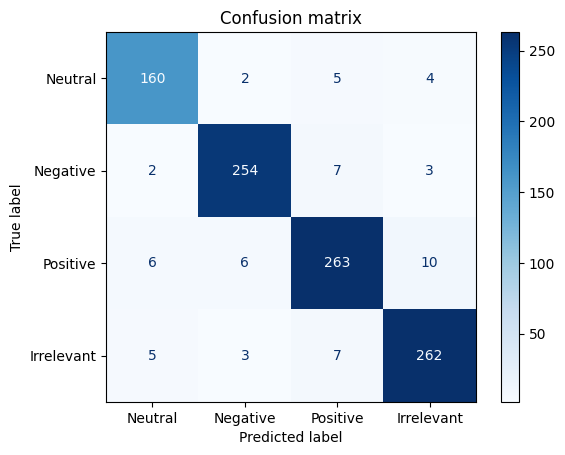

In [ ]:
cm = confusion_matrix(y_true_val, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = y_val.unique())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

In [52]:
https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
https://www.kaggle.com/code/jvrco22/twitter-sentiment-analysis-96-val-acc#Models

https://www.reddit.com/r/learnpython/comments/fayicq/vscode_the_term_conda_is_not_recognized_as_the/?rdt=49293


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (3946219620.py, line 1)